# Assignment 2 - CIFAR10 

In [70]:
import os
import torch
import random
import numpy as np
from torch import nn
import hiddenlayer as hl
from torchviz import make_dot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Task 1 

- Select 3 random classes with 100 samples from each.

- Start by creating a random number generator. This will be used in tasks 3 and 4
too.

In [71]:
# Takes in three parameters
# nums = number of values we need, in task one it would be 3
# start and stop is the range, i.e, (0,9)


# Returns a list of unique randomly generator integers.

def number_generator(nums, start, stop):
    numbers = []
    # This second list isn't necessary but can check doubles if want.
    # There's probably a more efficient way to do this with hash-maps so doubles
    # aren't created but I'm not sure.
    doubles = []

    while(len(numbers) < nums):
        numR = random.randint(start,stop)
        if numR in numbers:
            doubles.append(numR)
        else:
            numbers.append(numR)
    
    return numbers

In [72]:
# Use this to match the corresponding numbers in the dataset.
classes=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Colours for plotting.
classColour=('pink', 'red', 'darkorange', 'gold', 'lightgreen', 'mediumseagreen', 'lightskyblue', 'navy', 'rebeccapurple', 'darkred')
# Individual markers for each class. 
classMarker=("o", "v", "h", "2", "s", "p", "P", "*", "X", "d")

In [73]:
classNums = number_generator(3,0,9)
print("The classes selected are:\n1) ", classes[classNums[0]],"\n2) ", classes[classNums[1]],"\n3) ",classes[classNums[2]])

The classes selected are:
1)  cat 
2)  bird 
3)  car


Now that we have our three randoom classes, let's load in the CIFAR10 dataset and select all samples within those classes.
<br>
After these sets have been created, randomly select 100 samples from each of them. Combine these 3, 100 sample 
sets into one called *dataFull*.

In [74]:
cache = "~/.cache.cifar"
data2 = CIFAR10(cache, transform = transforms.ToTensor())

# Takes roughly 30 seconds.
Set1 = [(data2[i][0], data2[i][1]) for i in range(len(data2)) if data2[i][1] == classNums[0]]

Set2 = [(data2[i][0], data2[i][1]) for i in range(len(data2)) if data2[i][1] == classNums[1]]

Set3 = [(data2[i][0], data2[i][1]) for i in range(len(data2)) if data2[i][1] == classNums[2]]
print(len(Set2))

Set1 = random.sample(Set1, 100)
Set2 = random.sample(Set2, 100)
Set3 = random.sample(Set3, 100)
dataFull = Set1 + Set2 + Set3 

5000


In [75]:
train_data1 = dataFull

Now explicitly name the X and y values for both the training and test sets where;
<br>

**X** is the data, the 32 by 32 RBG information. 
<br>

**y** is the numerical indicator of class.

In [76]:
ytrain = np.array([train_data1[i][1] for i in range(len(train_data1))])
Xtrain = np.array([np.array(train_data1[i][0]) for i in range(len(train_data1))])

Xtrain = torch.tensor(Xtrain).float()

Xtrain.shape

torch.Size([300, 3, 32, 32])

### Task 2 CNN Autoencoder
<br>
A very simple CNN autoencoder with a bottle-neck layer of 2 units.

- I did a convolutional layer and a *dense* linear layer. 

- The class **autoCNN**  encodes and decodes given data using ReLU throughout. The data is flattened and unflattened 
where necessary.

- The function **forward** runs through all the layers and flattens/unflattens, as well as performing a 
sigmoid activation function of the data at the end.

- I didn't manually calculate what numbers I needed for the *unflatten* or the *denseCode* functions. Instead I 
just went off error messages to make it work.

I probably could add more steps in each but since we only need to model to get embeddings I figured it's best to keep it simple and not break the code.

In [77]:
class autoCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Didn't think it was worth dropping data in the layers
        self.encode = nn.Sequential(
            nn.Conv2d(3,8,3,stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8,16,3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16,32,3,stride=2,padding=0),
            nn.ReLU(True)
            )
        
        self.flatten = nn.Flatten(start_dim=1)

        self.denseCode = nn.Sequential(
            nn.Linear(288, 128),
            nn.ReLU(True),
            nn.Linear(128, 2)
            )

        # Bottle-neck where it's reduced to 2.
        # Do everything backwards.

        self.decodeDense = nn.Sequential(
            nn.Linear(2,128),
            nn.ReLU(True),
            nn.Linear(128,32),
            nn.ReLU(True)
        )

        # Followed error output for this. 
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,1,1))



        self.convDecode = nn.Sequential(
            # ConvTranspose2d, "known as a deconvolution" 
            # Not the exactly the opposite but gets the data back to 
            # it's precovoluted state.
            nn.ConvTranspose2d(32,16,3,stride=2,padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,8,3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,3,23,stride=2,padding=1,output_padding=1)
        )

    def forward(self, x):
        # encode
        x = self.encode(x)
        x = self.flatten(x)
        x = self.denseCode(x)

        # decode
        x = self.decodeDense(x)
        x = self.unflatten(x)
        x = self.convDecode(x)
        x = torch.sigmoid(x)

        return x

Create the auto-encoder, called **model**
<br>

Did a test run to see if inputted training data **Xtrain** comes out the correct
shape.

In [78]:
model = autoCNN()
xhat = model.forward(Xtrain)
xhat.shape

torch.Size([300, 3, 32, 32])

Define the optimisation method and loss function. 

In [79]:
# Again similar from tutorial.
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
# Standard loss function for CNN
# From reading seems to be more suitable given the sigmoid activation.
loss = nn.BCELoss()

Train the model on the training data.
<br>
- Takes roughly 1-2 minutes.
<br>
- Loading bar at the bottom courtesy of Ryan 

- Stored the losses but didn't use/look at them

In [80]:
losses = {
    'train': [],
    'val':   []
}
print("|------------------------------------------------------------------------------|")
print(" ", end='', flush=True)
EPOCH = 500
for i in range(EPOCH):
    # Forward pass
    xhat = model.forward(Xtrain)

    # Loss
    l = loss(xhat, Xtrain)

    # Backward
    opt.zero_grad()
    l.backward()

    # Optimize
    opt.step()

    # Stats
    losses['train'].append(l.detach())
    if i in np.floor(np.linspace(start=0, stop=EPOCH, num=78)):
        print("#", end='', flush=True)
        # print(t, '\t', loss.item())
    

|------------------------------------------------------------------------------|
 #############################################################################

## Task 3 - 2D Representation - Training Data
<br>
Plot the 2D coordinates of all images in the training set with each class denoted by a symbol.
<br>

To get the embeddings I run the first 3 functions of the model, **encode**, **flatten** and **densecode** to collect all
embeddings for the training set. 

In [81]:
# Helper function for embedding given data
# Takes in given X data and the autoencoder model.

def embed_data(givenData, givenModel):
    embedGiven = model.encode(givenData)
    embedGiven = model.flatten(embedGiven)
    embedGiven = model.denseCode(embedGiven)

    # Couldn't extract the 2D values in it's tensor form.
    embedGiven = embedGiven.detach().numpy()

    return embedGiven

In [82]:
# Code for plotting the embeddings, once the coordinates are extracted. 
# Each class has it's own specific colour. 

# This is only used once but could be useful if you were testing new data
# with only samples from the 3 target classes.

def plot_embeddings(x1, y1, x2, y2, x3, y3, classVals, classCols, classMarks):
    plt.scatter(x1, y1, color=classCols[classVals[0]], marker=classMarks[classVals[0]])
    plt.scatter(x2, y2, color=classCols[classVals[1]], marker=classMarks[classVals[1]])
    plt.scatter(x3, y3, color=classCols[classVals[2]], marker=classMarks[classVals[2]])

    class1 = mlines.Line2D([], [], color=classCols[classVals[0]], marker=classMarks[classVals[0]], linestyle='None',
                            markersize=10, label=classes[classVals[0]])

    class2 = mlines.Line2D([], [], color=classCols[classVals[1]], marker=classMarks[classVals[1]], linestyle='None',
                            markersize=10, label=classes[classVals[1]])

    class3 = mlines.Line2D([], [], color=classCols[classVals[2]], marker=classMarks[classVals[2]], linestyle='None',
                            markersize=10, label=classes[classVals[2]])

    plt.legend(handles=[class1, class2, class3], bbox_to_anchor=(1.2,1))
    plt.show()

In [83]:
# Get the embeddings from the training set 
train_embed = embed_data(Xtrain, model)

- Split the data into X and y coordinates based on which class they belong to. This is achieved by matching the embedded samples with their class from ytrain. 

- The data should keep the same order after going through the model so can just match in order.

- Created a function **plot_lists** that takes in the embedded data, corresponding y values and class numbers that were selected in task 1.

- Returns 6 lists that have the values needed to plot the embeddings.

I made this function when I was randomly selecting from the training set only. Will do the random samples manually.

In [84]:
def plot_lists(emedded_data, yValues, classValues):
    x1 = []
    y1 = []

    x2 = []
    y2 = []

    x3 = []
    y3 = []

    for i in range (len(emedded_data)):
        if(yValues[i] == classValues[0]):
            x1.append(emedded_data[i][0])
            y1.append(emedded_data[i][1])

        elif(yValues[i] == classValues[1]):
            x2.append(emedded_data[i][0])
            y2.append(emedded_data[i][1])


        elif(yValues[i] == classValues[2]):
            x3.append(emedded_data[i][0])
            y3.append(emedded_data[i][1])

    return x1, y1, x2, y2, x3, y3

In [85]:
plt1_X, plt1_y, plt2_X, plt2_y, plt3_X, plt3_y = plot_lists(train_embed, ytrain, classNums)

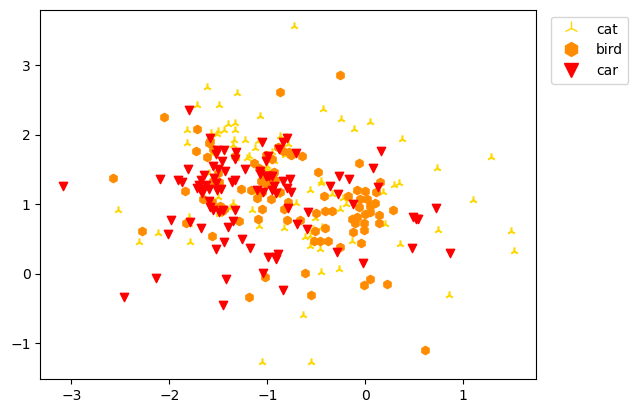

In [86]:
plot_embeddings(plt1_X, plt1_y, plt2_X, plt2_y, plt3_X, plt3_y, classNums, classColour, classMarker)

## Task 4 - 2D Representation - Sample data
<br>

- *Randomly* select 5 images not in the training set.

- Similarly to task 3, run the test samples halfway through the auto-encoder to get the 2D embeddings. 

- Then transform to numpy.

In [96]:
# Indicies of 5 samples.
sample_inds = number_generator(5,0,49999)

sample_inds

[21957, 9572, 33564, 970, 1713]

In [88]:
# Take the indicies an get the corresponding data into a list, sample_data

sample_data = []
for i in range(len(sample_inds)):
    sample_data.append(data2[sample_inds[i]])
len(sample_data)

5

- Same as code in task one.

- y_samples is the label, or class

- X_samples is the data.

In [89]:
y_samples = np.array([sample_data[i][1] for i in range(len(sample_data))])
X_samples = np.array([np.array(sample_data[i][0]) for i in range(len(sample_data))])

X_samples = torch.tensor(X_samples).float()

Had to use **item()** to make the values in **y_tester** int.


In [90]:
for i in range(len(y_samples)):
    y_samples[i] = y_samples[i].item()

In [91]:
# Run the 5 samples through the model to extract the embeddings.
sample_embed = embed_data(X_samples, model)

- I greyed out the original plot points to make it clear where the ones are/what colour they are. Also made the new points larger.

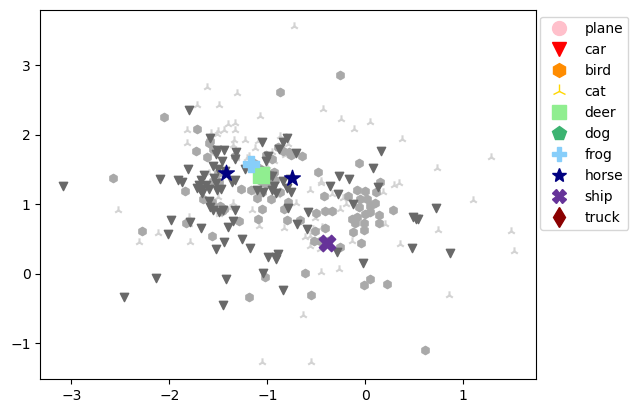

In [92]:
plt.scatter(plt1_X, plt1_y, color='lightgrey', marker=classMarker[classNums[0]])
plt.scatter(plt2_X, plt2_y, color='darkgrey', marker=classMarker[classNums[1]])
plt.scatter(plt3_X,plt3_y, color='dimgray', marker=classMarker[classNums[2]])

for i in range(len(sample_embed)):
    plt.scatter(sample_embed[i][0],sample_embed[i][1], color=classColour[y_samples[i]], marker=classMarker[y_samples[i]], s =140)

plot_class = []

for i  in range(10):
    cl = mlines.Line2D([], [], color=classColour[i], marker=classMarker[i], linestyle='None',
                        markersize=10, label=classes[i])
    plot_class.append(cl)

plt.legend(handles=[plot_class[0], plot_class[1], plot_class[2], plot_class[3], plot_class[4], 
            plot_class[5], plot_class[6], plot_class[7], plot_class[8], plot_class[9]], bbox_to_anchor=(1.2,1))
plt.show()

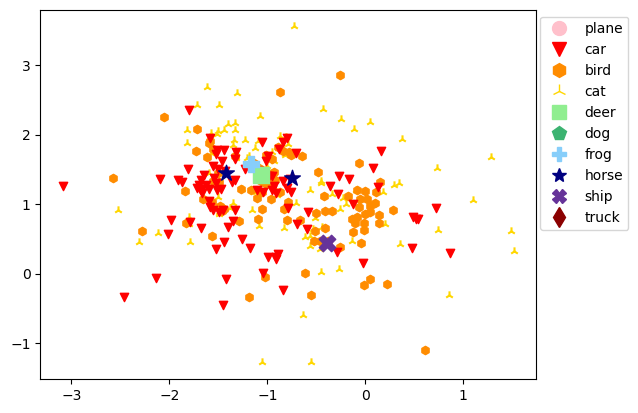

In [93]:
plt.scatter(plt1_X, plt1_y, color=classColour[classNums[0]], marker=classMarker[classNums[0]])
plt.scatter(plt2_X, plt2_y, color=classColour[classNums[1]], marker=classMarker[classNums[1]])
plt.scatter(plt3_X,plt3_y, color=classColour[classNums[2]], marker=classMarker[classNums[2]])

for i in range(len(sample_embed)):
    plt.scatter(sample_embed[i][0],sample_embed[i][1], color=classColour[y_samples[i]], marker=classMarker[y_samples[i]], s =140)

plot_class = []

for i  in range(10):
    cl = mlines.Line2D([], [], color=classColour[i], marker=classMarker[i], linestyle='None',
                        markersize=10, label=classes[i])
    plot_class.append(cl)

plt.legend(handles=[plot_class[0], plot_class[1], plot_class[2], plot_class[3], plot_class[4], 
            plot_class[5], plot_class[6], plot_class[7], plot_class[8], plot_class[9]], bbox_to_anchor=(1.2,1))
plt.show()

#### Comment on plot: 

This will be included in the readme file since plots will be different each time the program is run.
